100%|██████████| 14190/14190 [06:56<00:00, 34.07it/s] 


Epoch 1/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0325 - loss: 3.8426 - top_3_categorical_accuracy: 0.1014
Epoch 1: val_loss improved from inf to 4.81943, saving model to ./model/ann/ann.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.0325 - loss: 3.8413 - top_3_categorical_accuracy: 0.1016 - val_accuracy: 0.0560 - val_loss: 4.8194 - val_top_3_categorical_accuracy: 0.1381 - learning_rate: 0.0010
Epoch 2/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0636 - loss: 3.4592 - top_3_categorical_accuracy: 0.1679
Epoch 2: val_loss improved from 4.81943 to 4.14286, saving model to ./model/ann/ann.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.0637 - loss: 3.4584 - top_3_categorical_accuracy: 0.1682 - val_accuracy: 0.0867 - val_loss: 4.1429 - val_top_3_categorical_accuracy: 0.1959 - learning_rate: 0.0010
Epoch 3/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1049 - loss: 3.1858 - top_3_categorical_accuracy: 0.2541
Epoch 3: val_loss 

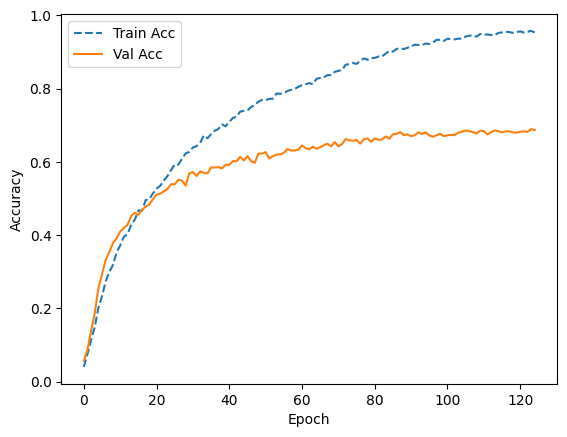

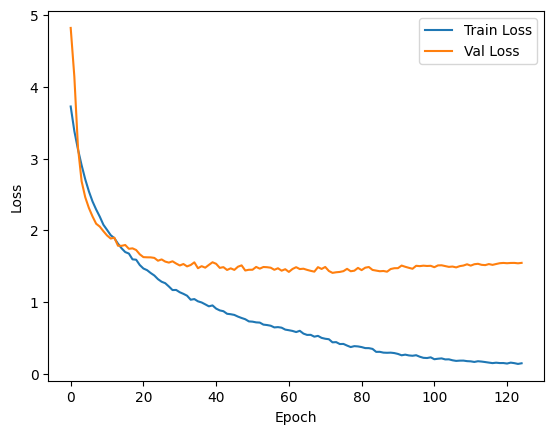

In [7]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization)
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

# Parameters
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)
batch_size = 128
epochs = 125
folder = './dataset/'
disk_folder = "./model/ann/"
data_info = ['letters.csv', 'letters2.csv', 'letters3.csv']

# Load and combine CSVs
def import_data(data_info):
    data = pd.read_csv(folder + '/' + data_info)
    data['source'] = data_info[:-4] + '/'
    return data

letters = [import_data(file) for file in data_info]
data = pd.concat(letters, ignore_index=True)
data = shuffle(data, random_state=42)

letters = ''.join(sorted(data.letter.unique()))
labels = data.label

# One-hot encoding
def ohe_letter(label):
    result = np.zeros(len(letters))
    result[letters.index(label)] = 1
    return result

data['enc_letter'] = data['letter'].apply(ohe_letter)

# Image preprocessing
def preprocess_image(path, size=(img_width, img_height)):
    # Load in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Resize
    img = cv2.resize(img, size)

    # Denoise using GaussianBlur
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Apply adaptive thresholding
    img = cv2.adaptiveThreshold(img, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 2)

    # Normalize
    img = img.astype(np.float32) / 255.0

    # Apply 'bone' colormap
    bone_colored = cm.bone(img)
    bone_colored = (bone_colored[:, :, :3] * 255).astype(np.uint8)
    bone_colored = bone_colored.astype('float32') / 255.0

    return bone_colored

images, encoded_labels = [], []

for _, row in tqdm(data.iterrows(), total=len(data)):
    path = os.path.join(folder + row['source'], row['file'])
    img = preprocess_image(path)
    images.append(img)
    encoded_labels.append(row['enc_letter'])

X = np.array(images)
y = np.array(encoded_labels)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  stratify=y,
                                                  random_state=42)

# Model
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model = Sequential([
    Input(shape=input_shape),
    Flatten(),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.05),
    Dense(len(letters), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', top_3_categorical_accuracy]
)

# Callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=2, factor=0.75)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(disk_folder, "ann.keras"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, lr_reduction])

# Plot accuracy
plt.plot(history.history['accuracy'], '--', label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()


100%|██████████| 1650/1650 [00:04<00:00, 391.78it/s]


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8799 - loss: 0.5922 - top_3_categorical_accuracy: 0.9215
Test Loss: 0.6368
Test Accuracy: 0.8727
Top-3 Accuracy: 0.9127
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
True: а - Predicted: а


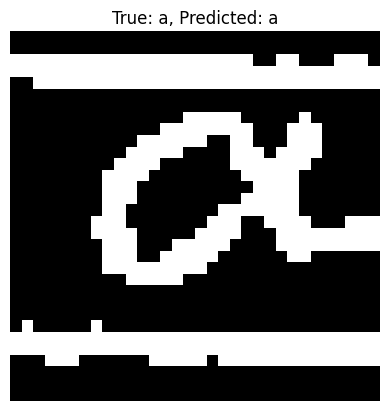

True: а - Predicted: я


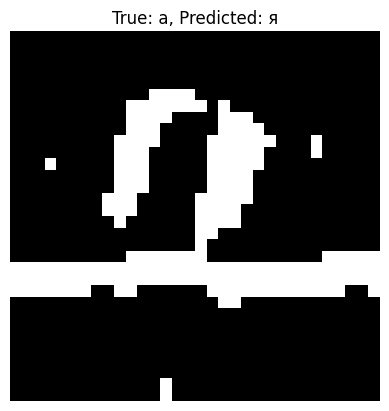

True: а - Predicted: а


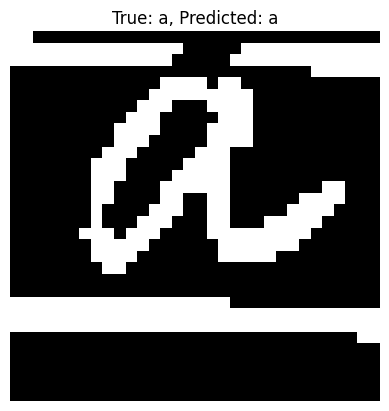

True: а - Predicted: а


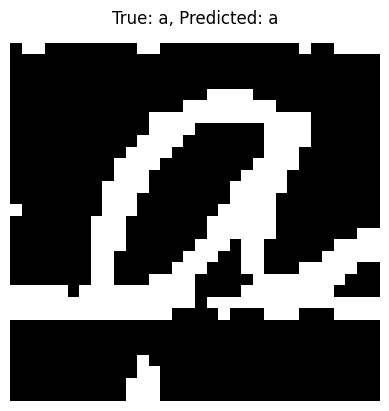

True: а - Predicted: а


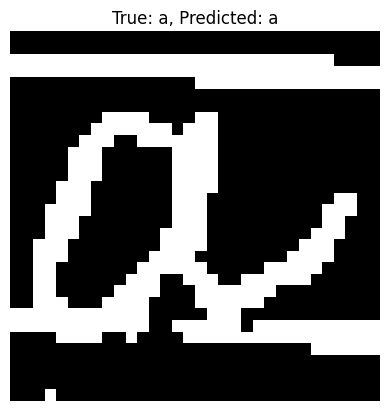

True: а - Predicted: а


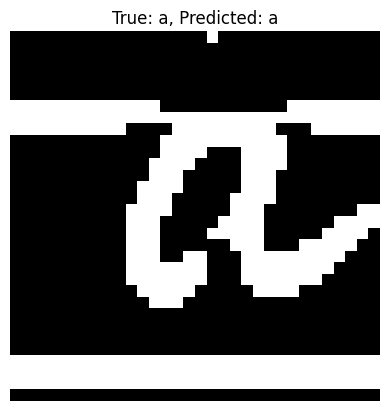

True: а - Predicted: а


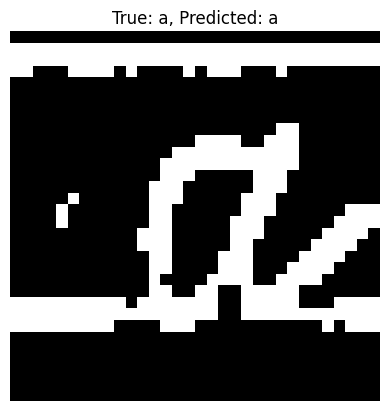

True: а - Predicted: а


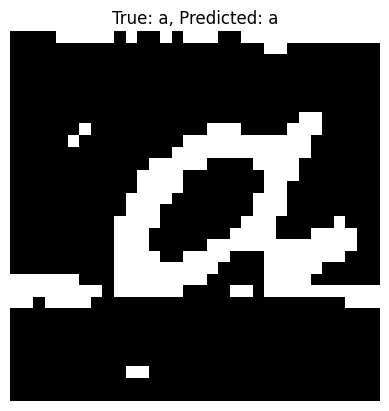

True: а - Predicted: а


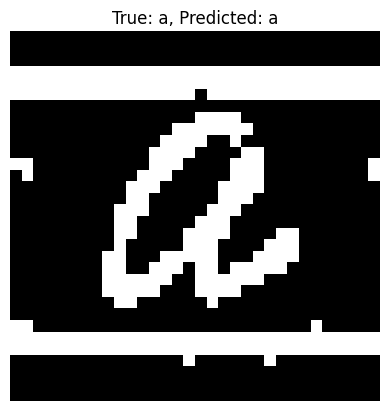

True: а - Predicted: а


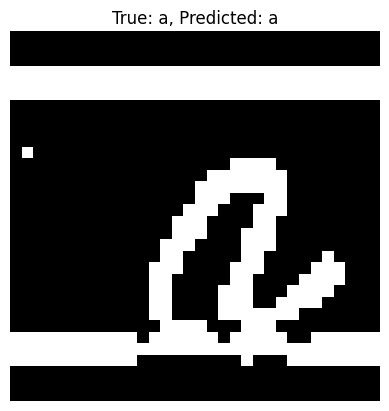

In [12]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model(os.path.join(disk_folder, "ann.keras"),
                   custom_objects={"top_3_categorical_accuracy": top_3_categorical_accuracy})

# Load the test dataset (e.g., letters.csv)
test_data_path = os.path.join(folder, 'letters.csv')
test_df = pd.read_csv(test_data_path)
test_df['source'] = 'letters/'  # Adjust if your folder name is different

# Preprocess test images
test_images, test_labels = [], []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    path = os.path.join(folder + row['source'], row['file'])
    img = preprocess_image(path)
    test_images.append(img)
    test_labels.append(ohe_letter(row['letter']))

X_test = np.array(test_images)
y_test = np.array(test_labels)

# Evaluate the model on test data
loss, acc, top3_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")

# Predict on test data
predictions = model.predict(X_test)
predicted_labels = [letters[np.argmax(p)] for p in predictions]
true_labels = [letters[np.argmax(t)] for t in y_test]

# Print a few random predictions
for i in range(10):
    print(f"True: {true_labels[i]} - Predicted: {predicted_labels[i]}")
    # Optionally, display the image
    plt.imshow(X_test[i])
    plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
    plt.show()